In [22]:
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import torchvision


from datasets import *
from models import *

import torch
from collections import OrderedDict
import matplotlib.pyplot as plt

output_path = "/root/autodl-tmp/output/dualGAN"
data_path="/root/autodl-tmp/FLIR_ADAS_v2"
epoch = 0
timestamp = "20220604_110426"
batch_size = 8
n_cpu = 8

############################################## keep the same as dualgan.py ################################################
G_AB_0 = Generator(3,3,is_A2B=True)
# G_BA_0 = Generator(3,3)
# D_A_0 = Discriminator(3)
# D_B_0 = Discriminator(3)
G_AB_0.load_state_dict(torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp, epoch)))
# G_BA_0.load_state_dict(torch.load("%s/saved_models/%s/G_BA_%d.pth" % (output_path, timestamp, epoch)))
# D_A_0.load_state_dict(torch.load("%s/saved_models/%s/D_A_%d.pth" % (output_path, timestamp, epoch)))
# D_B_0.load_state_dict(torch.load("%s/saved_models/%s/D_B_%d.pth" % (output_path, timestamp, epoch)))

G_AB_1 = Generator(3,3,is_A2B=True)
# G_BA_1 = Generator(3,3)
# D_A_1 = Discriminator(3)
# D_B_1 = Discriminator(3)
G_AB_1.load_state_dict(torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp, epoch)))
# G_BA_1.load_state_dict(torch.load("%s/saved_models/%s/G_BA_%d.pth" % (output_path, timestamp, epoch)))
# D_A_1.load_state_dict(torch.load("%s/saved_models/%s/D_A_%d.pth" % (output_path, timestamp, epoch)))
# D_B_1.load_state_dict(torch.load("%s/saved_models/%s/D_B_%d.pth" % (output_path, timestamp, epoch)))

# Configure dataloader
A_transforms = [
    # transforms.Grayscale(),    
    transforms.CenterCrop(size=1024),
    transforms.Resize(size=256,interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
B_transforms = [
    transforms.Grayscale(num_output_channels=3),
    transforms.CenterCrop(size=256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# train_dataloader = DataLoader(
#     ImageDataset("%s/images_rgb_train/data" % data_path, "%s/images_thermal_train/data" % data_path,
#                 A_transforms,B_transforms),
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=n_cpu,
# )
val_dataloader = DataLoader(
    ImageDataset("%s/images_rgb_val/data" % data_path, "%s/images_thermal_val/data" % data_path,
                A_transforms,B_transforms),
    batch_size=8,
    shuffle=True,
    num_workers=1,
)

############################################################################################################################

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

p_G_AB_0 = torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp, 12))
p_G_AB_1 = torch.load("%s/saved_models/%s/G_AB_%d.pth" % (output_path, timestamp, 84))

def interp(alpha,p_G_AB_0,p_G_AB_1):
    net_interp = OrderedDict()

    print('Interpolating with alpha = ', alpha)

    for k, v_G_AB_0 in p_G_AB_0.items():
        v_G_AB_1 = p_G_AB_1[k]
        net_interp[k] = (1 - alpha) * v_G_AB_0 + alpha * v_G_AB_1

    interp_G_AB = Generator(3,3,is_A2B=True)
    interp_G_AB.load_state_dict(net_interp)
    return interp_G_AB

/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [23]:
imgs = next(iter(val_dataloader))

Interpolating with alpha =  0.4


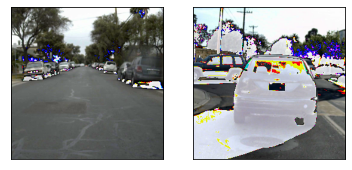

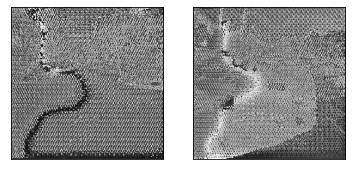

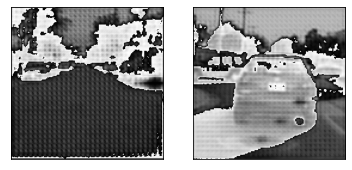

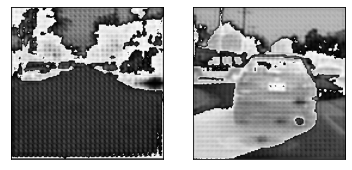

In [24]:
show(list(imgs['A'][:2]))
inter_G_AB = interp(0.4,p_G_AB_0,p_G_AB_1)
interp_img = inter_G_AB(imgs['A'])
show(list(interp_img[:2]))

img_0 = G_AB_0(imgs['A'])
show(list(img_0[:2]))
img_1 = G_AB_1(imgs['A'])
show(list(img_1[:2]))